In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split

from pygam import LinearGAM, s

In [143]:
df = pd.read_csv('./compresive_strength_concrete.csv')
df.isna().sum()

Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64

In [144]:
df.describe().loc[['mean','std','min','max']].round(2)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
mean,281.17,73.90,54.19,181.57,6.20,972.92,773.58,45.66,35.82
std,104.51,86.28,64.00,21.35,5.97,77.75,80.18,63.17,16.71
min,102.00,0.00,0.00,121.80,0.00,801.00,594.00,1.00,2.33
max,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


### Raw data scales

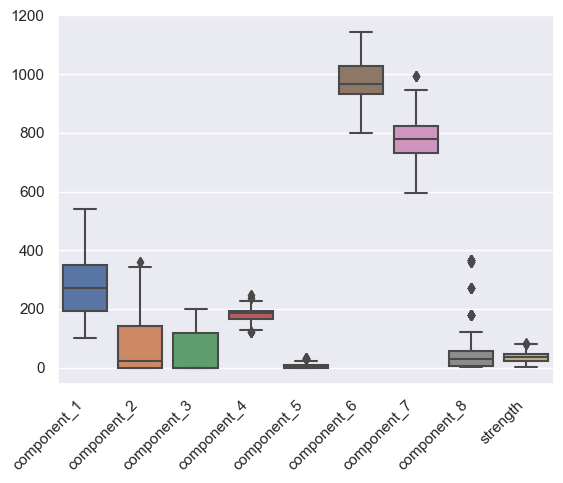

In [145]:
cols ={}

for n,i in enumerate(df.columns,1):
    if n!=9:
        cols[i]  =  'component_{}'.format(n)
    else:
        cols[i]  =  'strength'

df.rename(columns=cols,inplace=True)
fig0,ax0 = plt.subplots()
sns.boxplot(df,ax=ax0)
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=45,ha='right');

As can be seen the data has a very large change of scales.

Now I will check the correlations.

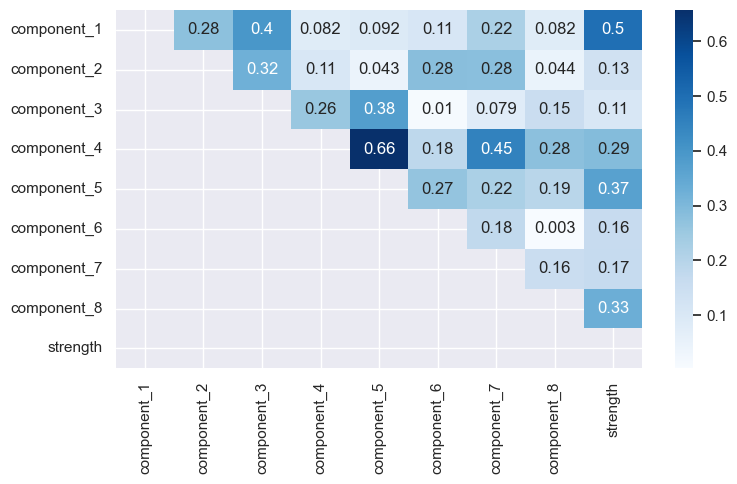

In [146]:
fig1, ax1 = plt.subplots(figsize=(8,5))
sns.heatmap(df.corr().abs(), cmap='Blues', annot=True, mask=np.tril(df.corr()))
plt.tight_layout()

In [147]:
qual_corr = df.corr().abs().sort_values(by='strength',ascending=False)
corr1 = qual_corr['strength']
corr1

strength       1.000000
component_1    0.497832
component_5    0.366079
component_8    0.328873
component_4    0.289633
component_7    0.167241
component_6    0.164935
component_2    0.134829
component_3    0.105755
Name: strength, dtype: float64

In [148]:
droppers = list(corr1.iloc[5:].index)
droppers.append('strength')
droppers

['component_7', 'component_6', 'component_2', 'component_3', 'strength']

Apparently all the ``components`` has fairly large correlation with the ``strength``. Nevertheless for the sake of this project we will not train the models with the whole datasets, just with the first 4 components. 

In [176]:
X = df.drop(droppers, axis=1)
y = df['strength']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=501,test_size=0.3)
sc = StandardScaler()
X_sc_train = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
X_sc_test  = pd.DataFrame(sc.transform(X_test),columns=X_train.columns)

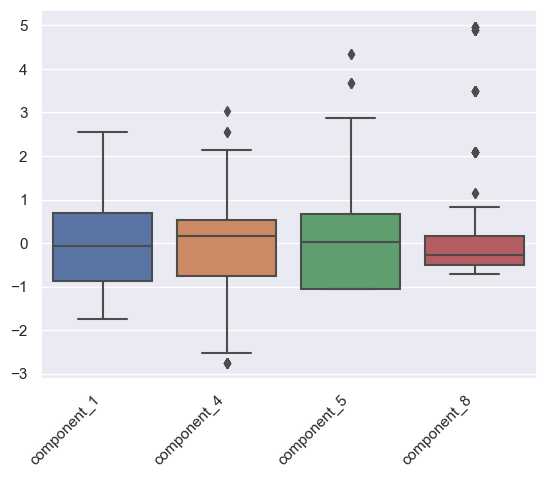

In [177]:
fig2,ax2 = plt.subplots()
sns.boxplot(X_sc_train,ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45,ha='right');

### GAM training

**Models without gridsearch**

In [179]:
#GAM model no scaled
full_splines = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)
partial_splines = s(0) + s(1) + s(2) + s(3) 

gam1 = LinearGAM( partial_splines,
                fit_intercept=True)
gam1.fit(X_train,y_train);

#GAM model scaled
gam2 = LinearGAM(partial_splines,
                fit_intercept=True)
gam2.fit(X_sc_train,y_train);


simple GAM metrics : Non scaled and scaled GAM

In [180]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
def report_gam_metrics (model, X_test, y_test):
    print( 'Test R^2: {0}' .format(r2_score(y_test, model.predict(X_test)).round( 3 )))
    print( 'Test RMSE: {0}' .format(np.sqrt(mean_squared_error(y_test, model.predict(X_test))).round( 3 )))
    print( 'Test Median Absolute Error: {0}' .format(median_absolute_error(y_test, model.predict(X_test)).round( 3 )))

print('Non scaled simple GAM')
report_gam_metrics(gam1, X_test, y_test)
print('Scaled simple GAM')
report_gam_metrics(gam2, X_sc_test, y_test)

Non scaled simple GAM
Test R^2: 0.752
Test RMSE: 8.15
Test Median Absolute Error: 5.138
Scaled simple GAM
Test R^2: 0.539
Test RMSE: 11.121
Test Median Absolute Error: 7.09


In [181]:
print('Non-scaled Summary',gam1.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     40.6407
Link Function:                     IdentityLink Log Likelihood:                                 -3687.5771
Number of Samples:                          721 AIC:                                             7458.4356
                                                AICc:                                            7463.6706
                                                GCV:                                               73.3191
                                                Scale:                                             65.9196
                                                Pseudo R-Squared:                                   0.7804
Feature Function                  Lam

/var/folders/p3/50_nj02131q_lcqnlf76q28w0000gn/T/ipykernel_1391/3575691374.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print('Non-scaled Summary',gam1.summary())


In [182]:
print('Scaled Summary',gam2.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.4642
Link Function:                     IdentityLink Log Likelihood:                                 -4201.4533
Number of Samples:                          721 AIC:                                              8417.835
                                                AICc:                                            8418.0123
                                                GCV:                                              137.1265
                                                Scale:                                            134.9153
                                                Pseudo R-Squared:                                   0.5279
Feature Function                  Lam

/var/folders/p3/50_nj02131q_lcqnlf76q28w0000gn/T/ipykernel_1391/2700049353.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print('Scaled Summary',gam2.summary())


GAM grid search scaled

In [184]:
# tradeoff coefficients
lambdas =  np.logspace(-3,3,4)
#tradeoff copies
lambdas = [lambdas] * len(X_train.columns)

full_splines = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)
partial_splines = s(0) + s(1) + s(2) + s(3)

gam3 = LinearGAM(partial_splines,
                fit_intercept=True)
gam3.gridsearch(X_sc_train.values,y_train,lam = lambdas);


  0% (0 of 256) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (3 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12
  1% (4 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12
  2% (7 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:11
  3% (10 of 256) |                       | Elapsed Time: 0:00:00 ETA:   0:00:11
  5% (13 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:11
  6% (16 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:11
  7% (19 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10
  8% (22 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10
  8% (23 of 256) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10
 10% (26 of 256) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10
 11% (29 of 256) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10
 11% (30 of 256) |##                    

In [185]:
gam3.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     33.9613
Link Function:                     IdentityLink Log Likelihood:                                 -3691.0056
Number of Samples:                          721 AIC:                                             7451.9337
                                                AICc:                                            7455.6043
                                                GCV:                                               72.3376
                                                Scale:                                             66.2314
                                                Pseudo R-Squared:                                   0.7772
Feature Function                  Lam

/var/folders/p3/50_nj02131q_lcqnlf76q28w0000gn/T/ipykernel_1391/3847374921.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam3.summary()


In [186]:
print('Grid Search scaled GAM ')
report_gam_metrics(gam3, X_sc_test, y_test)

Grid Search scaled GAM 
Test R^2: 0.742
Test RMSE: 8.311
Test Median Absolute Error: 5.017


In [187]:
# tradeoff coefficients
lambdas =  np.logspace(-3,3,4)
#tradeoff copies
lambdas = [lambdas] * len(X_train.columns)

partial_splines = s(0) + s(1) + s(2) + s(3) 

gam4 = LinearGAM(partial_splines,
                fit_intercept=False)
gam4.gridsearch(X_train.values,y_train,lam = lambdas);

  0% (0 of 256) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (2 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15
  1% (4 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17
  2% (6 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16
  3% (9 of 256) |                        | Elapsed Time: 0:00:00 ETA:   0:00:14
  3% (10 of 256) |                       | Elapsed Time: 0:00:00 ETA:   0:00:14
  4% (12 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:14
  5% (13 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:14
  5% (15 of 256) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:14
  6% (17 of 256) |#                      | Elapsed Time: 0:00:01 ETA:   0:00:14
  7% (19 of 256) |#                      | Elapsed Time: 0:00:01 ETA:   0:00:14
  8% (22 of 256) |#                      | Elapsed Time: 0:00:01 ETA:   0:00:13
  9% (25 of 256) |##                    

In [188]:
gam4.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     33.9613
Link Function:                     IdentityLink Log Likelihood:                                 -3691.0056
Number of Samples:                          721 AIC:                                             7451.9337
                                                AICc:                                            7455.6043
                                                GCV:                                               72.3376
                                                Scale:                                             66.2314
                                                Pseudo R-Squared:                                   0.7772
Feature Function                  Lam

/var/folders/p3/50_nj02131q_lcqnlf76q28w0000gn/T/ipykernel_1391/3649765879.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam4.summary()


In [189]:
print('Grid Search non scaled GAM ')
report_gam_metrics(gam4, X_test, y_test)

Grid Search non scaled GAM 
Test R^2: 0.742
Test RMSE: 8.311
Test Median Absolute Error: 5.017


SUMMARY of MODELS

In [190]:
print('\nNon scaled simple GAM')
report_gam_metrics(gam1, X_test, y_test)
print('\nScaled simple GAM')
report_gam_metrics(gam2, X_sc_test, y_test)
print('\nGrid Search scaled GAM ')
report_gam_metrics(gam3, X_sc_test, y_test)
print('\nGrid Search non scaled GAM ')
report_gam_metrics(gam4, X_test, y_test)


Non scaled simple GAM
Test R^2: 0.752
Test RMSE: 8.15
Test Median Absolute Error: 5.138

Scaled simple GAM
Test R^2: 0.539
Test RMSE: 11.121
Test Median Absolute Error: 7.09

Grid Search scaled GAM 
Test R^2: 0.742
Test RMSE: 8.311
Test Median Absolute Error: 5.017

Grid Search non scaled GAM 
Test R^2: 0.742
Test RMSE: 8.311
Test Median Absolute Error: 5.017


As can be seen the models with less RMSE are the non-scaled simple GAM and the GridSearch scaled and non scaled GAM models

### Partial Dependence

**Simple Scaled GAM**

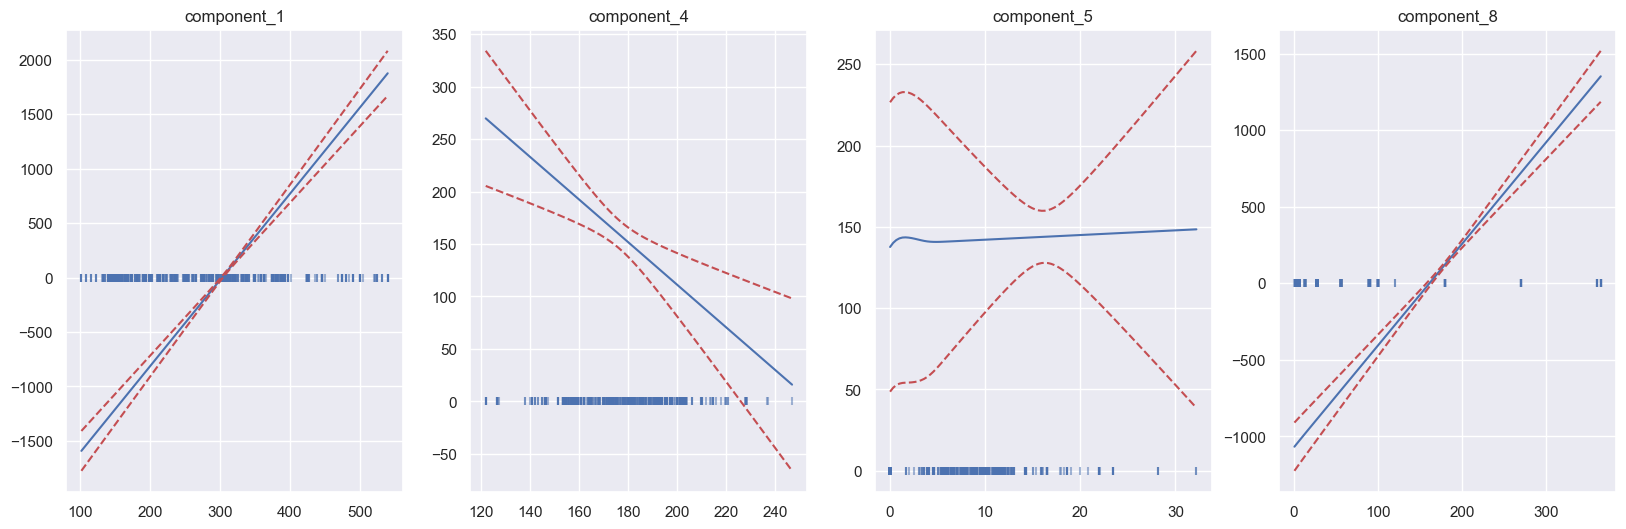

In [191]:
fig4, ax4 = plt.subplots( 1 , 4 , figsize = ( 20 , 6 ));

titles = X_train.columns

for i, ax in enumerate(ax4.flatten()):
    XX = gam2.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam2.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam2.partial_dependence(term=i, X=XX, width= .95 )[1], c= 'r' , ls= '--' )
    ax.scatter(X_train[titles[i]], [ 0 ] * len(X_train[titles[i]]), marker = '|', alpha = .5 )
    ax.set_title(titles[i]);

**Scaled GridSearch GAM**

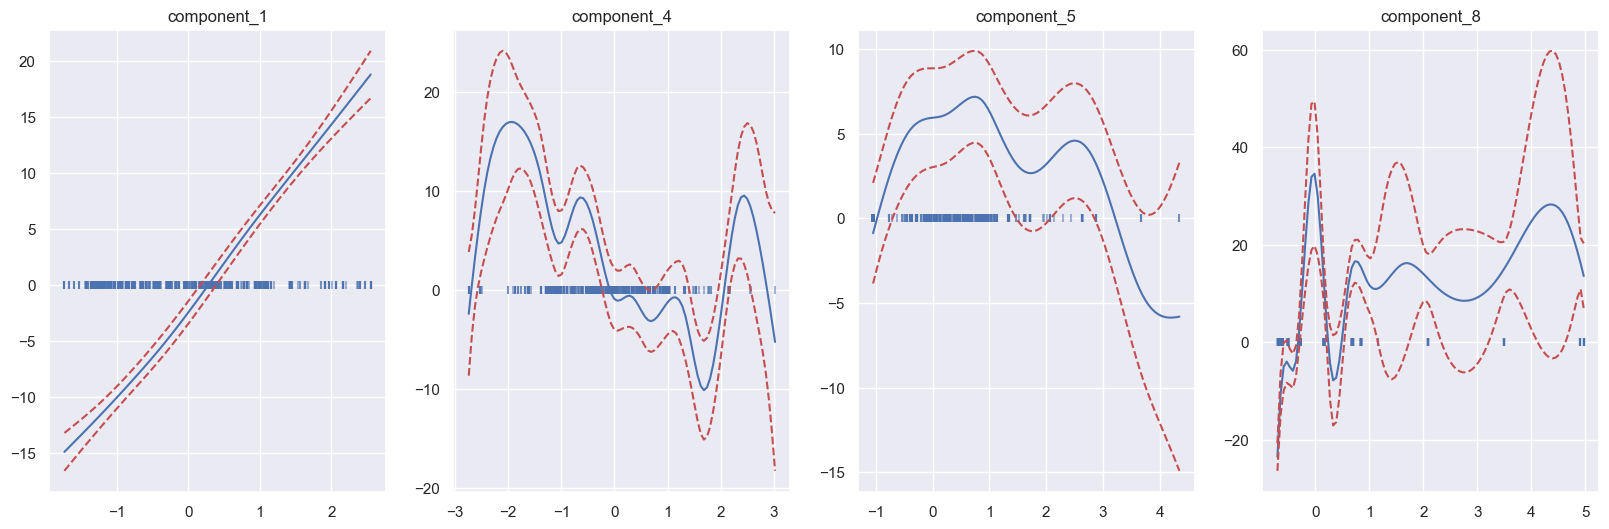

In [194]:
fig5, ax5 = plt.subplots( 1 , 4 , figsize = ( 20 , 6 ));

titles = X_train.columns

for i, ax in enumerate(ax5.flatten()):
    XX = gam3.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam3.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam3.partial_dependence(term=i, X=XX, width= .95 )[1], c= 'r' , ls= '--' )
    ax.scatter(X_sc_train[titles[i]], [ 0 ] * len(X_sc_train[titles[i]]), marker = '|', alpha = .5 )
    ax.set_title(titles[i]);

**Non-Scaled GridSearch GAM**

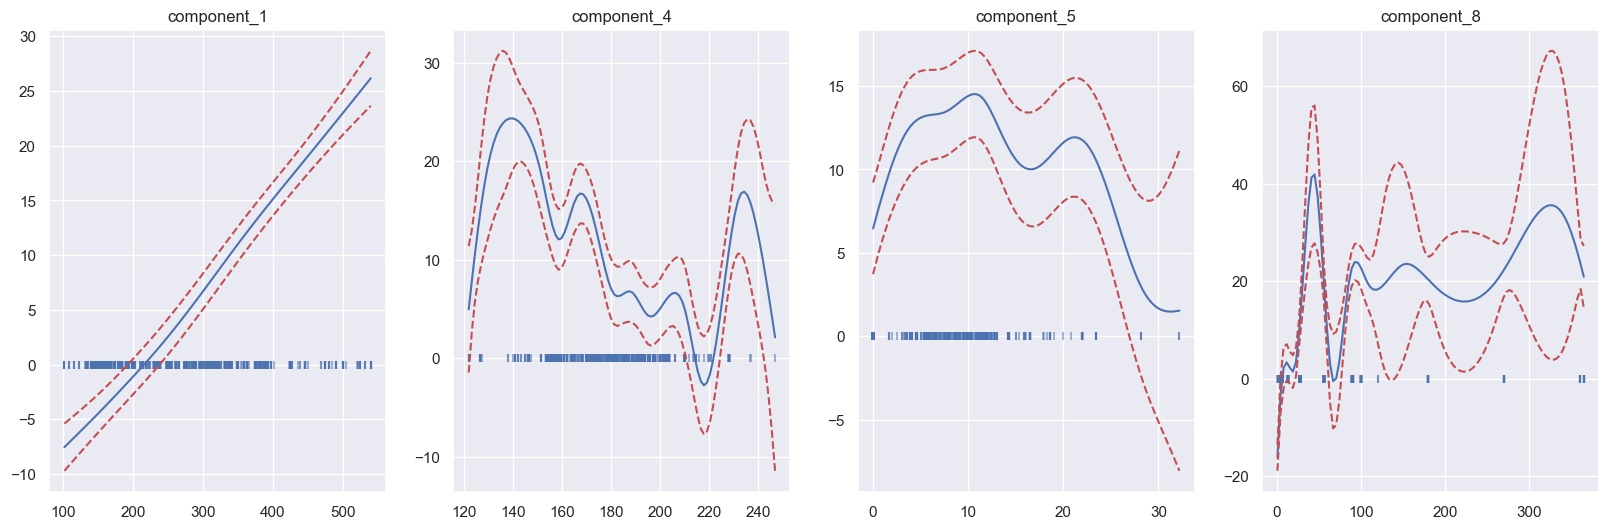

In [195]:
fig6, ax6 = plt.subplots( 1 , 4 , figsize = ( 20 , 6 ));

titles = X_train.columns

for i, ax in enumerate(ax6.flatten()):
    XX = gam4.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam4.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam4.partial_dependence(term=i, X=XX, width= .95 )[1], c= 'r' , ls= '--' )
    ax.scatter(X_train[titles[i]], [ 0 ] * len(X_train[titles[i]]), marker = '|', alpha = .5 )
    ax.set_title(titles[i]);